In [177]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import  train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import chi2
import xgboost as xgb

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [178]:
hierarchy = pd.read_csv("https://raw.githubusercontent.com/stasi009/TakeHomeDataChallenges/master/15.WorkPlace/company_hierarchy.csv",index_col='employee_id')
hierarchy['level'] = None # initialize 

# starting point
hierarchy.loc[hierarchy.dept == 'CEO','level'] = 'CEO'

# change all boss_id to integer
hierarchy.loc[hierarchy.level == 'CEO','boss_id'] = -1
hierarchy['boss_id'] = hierarchy.boss_id.astype(int)

def set_level(boss_level,level):
    boss_ids = hierarchy.loc[hierarchy.level == boss_level,:].index
    is_subordinate = np.in1d(hierarchy.boss_id,boss_ids)
    hierarchy.loc[is_subordinate,'level'] = level

set_level('CEO','E')
set_level('E','VP')
set_level('VP','D')
set_level('D','MM')
set_level('MM','IC')

In [179]:
hierarchy.head()

,boss_id,dept,level
employee_id,,,
46456,175361,sales,IC
104708,29733,HR,IC
120853,41991,sales,IC
142630,171266,HR,MM
72711,198240,sales,IC


In [180]:
employees = pd.read_csv("https://raw.githubusercontent.com/stasi009/TakeHomeDataChallenges/master/15.WorkPlace/employee.csv",index_col="employee_id")

# make the salary "N k", where k represents $1000, which is easier to display
employees["salary"] /= 1000

In [181]:
employees.head()

,signing_bonus,salary,degree_level,sex,yrs_experience
employee_id,,,,,
138719,0,273.0,Master,M,2
3192,0,301.0,Bachelor,F,1
114657,0,261.0,Master,F,2
29039,0,86.0,High_School,F,4
118607,0,126.0,Bachelor,F,3


In [182]:
employees = employees.join(hierarchy)

In [183]:
X = employees.copy()

X["is_male"] = (X.sex == "M").astype(int)
del X["sex"]

del X['boss_id']# I assume boss_id won't affect salary

In [184]:
employees["level"]= employees["level"].replace({'IC': 0, 'MM': 1, 'D': 2, 'VP': 3, 'E': 4, 'CEO': 5})

In [185]:
employees.degree_level = employees.degree_level.replace({"High_School":0,"Bachelor":1,"Master":2,"PhD":3})

In [186]:
employees.signing_bonus.value_counts()

0    6986
1    3014
Name: signing_bonus, dtype: int64

In [187]:
employees.degree_level = employees.degree_level.astype("category")
f2dummy= pd.get_dummies(employees.degree_level, prefix='degree_level')
employees1 = pd.concat([employees, f2dummy],axis=1)
employees2=employees1.drop("degree_level",axis=1)
employees2.dept = employees2.dept.astype("category")
f2dummy1= pd.get_dummies(employees2.dept, prefix='dept')
employees3 = pd.concat([employees2, f2dummy1],axis=1)
employees4=employees3.drop("dept",axis=1)

employees4.level = employees4.level.astype("category")
f2dummy3= pd.get_dummies(employees4.level, prefix='level')
employees4 = pd.concat([employees4, f2dummy3],axis=1)
employees3=employees3.drop("level",axis=1)

In [188]:
employees4["sex"]= employees4["sex"].replace({"M":1,"F":0})

In [189]:
employees4.sex = employees4.sex.astype("category")

In [190]:
del employees4["boss_id"]
del employees4["level"]

In [191]:
employees4.head()

,signing_bonus,salary,sex,yrs_experience,degree_level_0,degree_level_1,degree_level_2,degree_level_3,dept_CEO,dept_HR,dept_engineering,dept_marketing,dept_sales,level_0,level_1,level_2,level_3,level_4,level_5
employee_id,,,,,,,,,,,,,,,,,,,
138719,0,273.0,1,2,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
3192,0,301.0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0
114657,0,261.0,0,2,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0
29039,0,86.0,0,4,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
118607,0,126.0,0,3,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0


In [192]:
employees4['salary'] = np.log(employees4.salary)

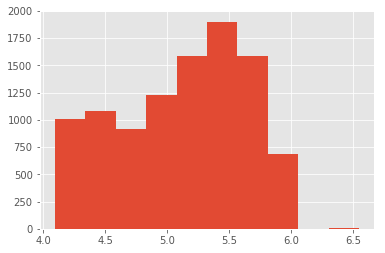

In [193]:
np.log(employees.salary).hist()

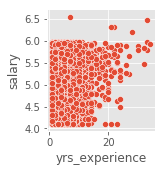

In [194]:
import seaborn as sns

sns.pairplot(employees4, x_vars='yrs_experience', y_vars='salary')

In [195]:
employees4.head()

,signing_bonus,salary,sex,yrs_experience,degree_level_0,degree_level_1,degree_level_2,degree_level_3,dept_CEO,dept_HR,dept_engineering,dept_marketing,dept_sales,level_0,level_1,level_2,level_3,level_4,level_5
employee_id,,,,,,,,,,,,,,,,,,,
138719,0,5.609472,1,2,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
3192,0,5.707110,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0
114657,0,5.564520,0,2,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0
29039,0,4.454347,0,4,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
118607,0,4.836282,0,3,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0


In [196]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object

#employees4.yrs_experience= employees4.yrs_experience.reshape(-1, 1)
employees4.yrs_experience = preprocessing.scale(employees4.yrs_experience)
#scaled_df = pd.DataFrame(scaled_df, columns=names)

C:\Users\akabo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [197]:
from sklearn.svm import SVR
y =employees4["salary"]
X= employees4.drop(["salary"],axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size = 0.20,random_state = 42)

In [198]:
svr= SVR(kernel='rbf', C=100, gamma=0.1)
svr_fit= svr.fit(X_train, y_train)
y_pred = svr_fit.predict(X_test)


In [199]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.3834075360215049

In [200]:
np.sqrt(mean_squared_error(y_test,y_pred))

0.4008632086033997

In [202]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,6,7,8,9,10],
    'max_features': [2, 3],
    'n_estimators': [70,80,90,100,110]
}
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)
grf = grid_search.fit(X_train, y_train)
y_pred = grf.predict(X_test)
y_pred1 = grf.predict_proba(X_test)
y_pro = y_pred1[:,1]

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.1min finished


AttributeError: 'RandomForestRegressor' object has no attribute 'predict_proba'

In [157]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.36186316988369505

In [158]:
np.sqrt(mean_squared_error(y_test,y_pred))

0.4078063626922201

In [159]:
model1.feature_importances_

In [160]:
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf_fit.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.7091, 'dept_HR'), (0.0938, 'yrs_experience'), (0.066, 'dept_engineering'), (0.0213, 'sex'), (0.0183, 'signing_bonus'), (0.013, 'degree_level_1'), (0.0116, 'degree_level_2'), (0.011, 'degree_level_3'), (0.0106, 'degree_level_0'), (0.0099, 'level_1'), (0.0092, 'dept_sales'), (0.009, 'level_0'), (0.0079, 'dept_marketing'), (0.0041, 'level_2'), (0.0035, 'level_3'), (0.001, 'level_5'), (0.0006, 'level_4'), (0.0004, 'dept_CEO')]


In [161]:
X.columns.values

array(['signing_bonus', 'sex', 'yrs_experience', 'degree_level_0',
       'degree_level_1', 'degree_level_2', 'degree_level_3', 'dept_CEO',
       'dept_HR', 'dept_engineering', 'dept_marketing', 'dept_sales',
       'level_0', 'level_1', 'level_2', 'level_3', 'level_4', 'level_5'],
      dtype=object)

In [162]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm

model = lgbm.LGBMRegressor()
model1 = model.fit(X_train, y_train)
y_pred = model1.predict(X_test)

In [163]:
np.sqrt(mean_squared_error(y_test,y_pred))

0.39164535374681053

In [164]:
b= pd.Series(model1.feature_importances_)

In [165]:
X.columns

Index(['signing_bonus', 'sex', 'yrs_experience', 'degree_level_0',
       'degree_level_1', 'degree_level_2', 'degree_level_3', 'dept_CEO',
       'dept_HR', 'dept_engineering', 'dept_marketing', 'dept_sales',
       'level_0', 'level_1', 'level_2', 'level_3', 'level_4', 'level_5'],
      dtype='object')

In [166]:
b= pd.Series(model1.feature_importances_)
a=pd.Series(X.columns)
c=pd.concat([a,b],axis=1)
c

,0,1
0,signing_bonus,241
1,sex,243
2,yrs_experience,1265
3,degree_level_0,99
4,degree_level_1,145
5,degree_level_2,134
6,degree_level_3,164
7,dept_CEO,0
8,dept_HR,88
9,dept_engineering,110
